# Synthetic Data for Ridgecrest

In [27]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## 1. Configuration

In [16]:
config = {'center':      (-117.504, 35.705), 
          'xlim_degree': [-118.004, -117.004], 
          'ylim_degree': [35.205, 36.205], 
          'zlim_km':     [0, 20],
          'degree2km':   111.19492474777779, 
          }
config["x(km)"] = [(x -config["center"][0])*config["degree2km"] for x in config["xlim_degree"]]
config["y(km)"] = [(x -config["center"][1])*config["degree2km"] for x in config["ylim_degree"]]
config["z(km)"] = config["zlim_km"]
config["starttime"] = "2019-01-01"

with open("config.json", "w") as f:
    json.dump(config, f, indent=2)
print(config)

{'center': (-117.504, 35.705), 'xlim_degree': [-118.004, -117.004], 'ylim_degree': [35.205, 36.205], 'zlim_km': [0, 20], 'degree2km': 111.19492474777779, 'x(km)': [-55.597462373888895, 55.597462373888895], 'y(km)': [-55.597462373888895, 55.597462373888895], 'z(km)': [0, 20], 'starttime': '2019-01-01'}


## 2. Station Locations

In [17]:
stations = pd.read_csv('stations_ridgecrest.csv', sep="\t")
stations["tmp"] = stations.apply(lambda x: x["station"][-3:], axis=1)
stations = stations[stations["tmp"] == ".HN"]
stations.drop(["tmp"], axis=1, inplace=True)
stations.reset_index(inplace=True, drop=True)
stations["x(km)"] = stations["longitude"].apply(lambda x: (x - config["center"][0])*config["degree2km"])
stations["y(km)"] = stations["latitude"].apply(lambda x: (x - config["center"][1])*config["degree2km"])
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)
# stations["z(km)"] = stations["elevation(m)"].apply(lambda x: 0)

station_loc = np.array([[stations["x(km)"][i], stations["y(km)"][i], stations["z(km)"][i]] for i in range(len(stations))])

stations.to_csv("synthetic_stations.csv", sep="\t", index=False)
stations.to_json("synthetic_stations.json")

## 3. Generate Picks

In [18]:
## relationship for magnitude and velocity
c0, c1, c2, c3 = 1.08, 0.93, -0.015, -1.68
vp = 6.0
vs = 6.0/1.75
vp *= 0.9
vs *= 0.9
phase_amp_err = 0.4
phase_time_err = 0.4
phase_fp_rate = 0.4
# vp *= 1.0
# vs *= 1.0
# phase_amp_err = 0.0
# phase_time_err = 0.0
# phase_fp_rate = 0.0


## data
phase_event_idx = []
phase_time = []
phase_amp = []
phase_type = []
phase_loc = []
phase_prob = []
phase_station = []
phase_station_id = []
num_event = 50
num_station = len(station_loc)


## random events
np.random.seed(123)
event_t0 = np.linspace(0, (num_event-1)*10, num_event)
event_mag = np.linspace(1, 5, num_event)
np.random.shuffle(event_mag)
event_loc = np.zeros((num_event,3))
dx = config["x(km)"][1] - config["x(km)"][0]
event_loc[:,0] = np.linspace(config["x(km)"][0] + dx*0.1, config["x(km)"][1] - dx*0.1, num_event)
np.random.shuffle(event_loc[:,0])
dy = config["y(km)"][1] - config["y(km)"][0]
event_loc[:,1] = np.linspace(config["y(km)"][0] + dy*0.1, config["y(km)"][1] - dy*0.1, num_event)
np.random.shuffle(event_loc[:,1])
dz = config["z(km)"][1] - config["z(km)"][0]
event_loc[:,2] = np.linspace(config["z(km)"][0] + dz*0.2, config["z(km)"][1] - dz*0.2, num_event)
np.random.shuffle(event_loc[:,2])

## random picks
for i in range(num_event):
    mag = event_mag[i]
    loc = event_loc[i, :]
    t0 = event_t0[i]
    dist = np.sqrt(np.sum((loc - station_loc)**2, axis=1))
    tp = t0 + dist / vp
    ts = t0 + dist / vs
    logA = c0 + c1 * (mag - 3.5) + c3 * np.log10(dist) - 2 ## m/s
    # print(logA)
    # tp_err = np.random.uniform(
    #     low=-phase_time_err, high=phase_time_err, size=num_station
    # )
    # ts_err = np.random.uniform(
    #     low=-phase_time_err, high=phase_time_err, size=num_station
    # )
    # logA_p_err = np.random.uniform(
    #     low=-phase_amp_err, high=phase_amp_err, size=num_station
    # )
    # logA_s_err = np.random.uniform(
    #     low=-phase_amp_err, high=phase_amp_err, size=num_station
    # )
    tp_err = np.random.randn(num_station) * phase_time_err
    ts_err = np.random.randn(num_station) * phase_time_err
    logA_p_err = np.random.randn(num_station) * phase_amp_err
    logA_s_err = np.random.randn(num_station) * phase_amp_err
    for j in range(num_station):
        # if logA[j] > -6:
        if True:
            # if np.random.rand() < 0.8:
            if True:
                phase_time.append(tp[j] + tp_err[j])  # p
                phase_amp.append(logA[j] + logA_p_err[j])
                phase_type.append("p")
                phase_loc.append(station_loc[j])
                phase_event_idx.append(i)
                phase_station.append(j)
                phase_station_id.append(stations.iloc[j]["station"])
                phase_prob.append(10**(-abs(tp_err[j])/(phase_time_err + 1e-6)))
                # phase_prob.append(1)
            # if np.random.rand() < 0.8:
            if True:
                phase_time.append(ts[j] + ts_err[j])  # s
                phase_amp.append(logA[j] + logA_s_err[j])
                phase_type.append("s")
                phase_loc.append(station_loc[j])
                phase_event_idx.append(i)
                phase_station.append(j)
                phase_station_id.append(stations.iloc[j]["station"])
                phase_prob.append(10**(-abs(ts_err[j])/(phase_time_err + 1e-6)))
                # phase_prob.append(1)

np.random.seed(1234)
min_phase_time, max_phase_time = min(phase_time), max(phase_time)
min_phase_amp, max_phase_amp = min(phase_amp), max(phase_amp)
for i in range(int(len(phase_time) * phase_fp_rate)):
    phase_time.append(np.random.uniform(min_phase_time, max_phase_time))
    phase_amp.append(np.random.uniform(min_phase_amp, max_phase_amp))
    phase_type.append(np.random.choice(["p", "s"]))
    station_idx = np.random.randint(num_station)
    phase_loc.append(station_loc[station_idx])
    phase_event_idx.append(-1)
    phase_station.append(station_idx)
    phase_station_id.append(stations.iloc[j]["station"])
    phase_prob.append(10**(-np.random.rand()))
    # phase_prob.append(1)


event_loc = np.vstack(event_loc)
event_mag = np.array(event_mag)
event_t0 = np.array(event_t0)
phase_time = np.array(phase_time)[:, np.newaxis]
phase_prob = np.array(phase_prob)[:, np.newaxis]
phase_amp = np.array(phase_amp)[:, np.newaxis]
phase_loc = np.array(phase_loc)
phase_station = np.array(phase_station)
phase_event_idx = np.array(phase_event_idx)

## 4. Save Picks

In [19]:
events = pd.DataFrame({"time": [(datetime.fromisoformat(config["starttime"]) + timedelta(seconds=x)).isoformat(timespec='milliseconds') for x in  event_t0],
                       "magnitude": event_mag, 
                       "longitude": [config["center"][0] + x for x in event_loc[:,0]/config["degree2km"]],
                       "latitude": [config["center"][1] + x for x in event_loc[:,1]/config["degree2km"]],
                       "depth(m)": event_loc[:,2].squeeze()*1e3,
                       "x(km)": event_loc[:,0].squeeze(),
                       "y(km)": event_loc[:,1].squeeze(),
                       "z(km)": event_loc[:,2].squeeze(),
                       })

In [20]:
events.to_json("synthetic_events.json")
events.to_csv("synthetic_events.csv", sep="\t", index=False)

In [21]:
picks = pd.DataFrame({"timestamp": [(datetime.fromisoformat(config["starttime"]) + timedelta(seconds=x)).isoformat(timespec='milliseconds') for x in  phase_time.squeeze()], 
                      "type": phase_type, 
                      "amp":  10**(phase_amp.squeeze()),
                      "prob": phase_prob.squeeze(),
                      "station_id": phase_station_id,
                      "event_id": phase_event_idx.squeeze()})


In [22]:
picks.to_json("synthetic_picks.json")
picks.to_csv("synthetic_picks.csv", sep="\t", index=False)

In [23]:
print(f"Number of statations: {num_station}")
print(f"Number of events: {num_event}")
print(f"Number of picks: {len(picks)}")

Number of statations: 25
Number of events: 50
Number of picks: 3500


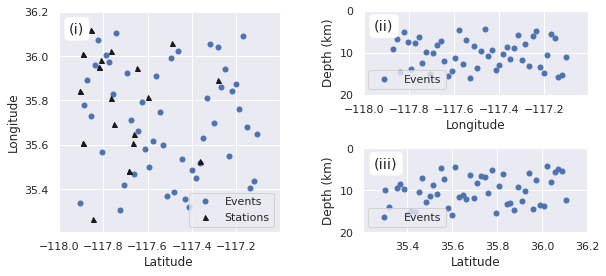

In [39]:
markersize = 10

fig = plt.figure(figsize=plt.rcParams["figure.figsize"] * np.array([1.5, 1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1, 1])
fig.add_subplot(grd[:, 0])
plt.plot(events["longitude"], events["latitude"], '.', markersize=markersize, alpha=1.0)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])) 
plt.ylim(np.array(config["ylim_degree"])) 
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(
    config["xlim_degree"][0] - 10,
    config["ylim_degree"][0] - 10,
    '.',
    markersize=10,
    label=f"Events",
    rasterized=True,
)
plt.plot(
    stations["longitude"],
    stations["latitude"],
    'k^',
    markersize=5,
    alpha=1.0,
    label="Stations",
)
plt.legend()
plt.text(
    text_loc[0],
    text_loc[1]+0.05,
    '(i)',
    horizontalalignment='left',
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)

fig.add_subplot(grd[0, 1])
plt.plot(
    events["longitude"],
    events["depth(m)"] / 1e3,
    '.',
    markersize=markersize,
    alpha=1.0,
    rasterized=True,
)
# plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))  # +np.array([0.2,-0.27]))
plt.ylim(config["zlim_km"])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0] - 10, 31, '.', markersize=10, label=f"Events")
plt.legend(loc="lower left")
plt.text(
    text_loc[0],
    text_loc[1],
    '(ii)',
    horizontalalignment='left',
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)

fig.add_subplot(grd[1, 1])
plt.plot(
    events["latitude"],
    events["depth(m)"] / 1e3,
    '.',
    markersize=markersize,
    alpha=1.0,
    rasterized=True,
)
# plt.axis("scaled")
plt.xlim(np.array(config["ylim_degree"]))  # +np.array([0.2,-0.27]))
plt.ylim(config["zlim_km"])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0] - 10, 31, '.', markersize=10, label=f"Events")
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(
    text_loc[0],
    text_loc[1],
    '(iii)',
    horizontalalignment='left',
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)
plt.savefig("synthetic_earthquake_location.png", bbox_inches="tight", dpi=300)
plt.savefig("synthetic_earthquake_location.pdf", bbox_inches="tight", dpi=300)
plt.show()



(0.0, 100.0)

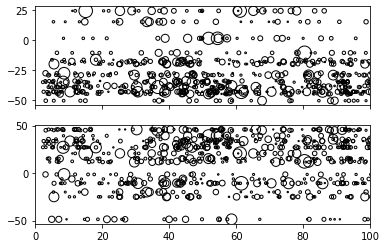

In [25]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].scatter(phase_time, phase_loc[:,0], s=2**(phase_amp + 8), marker="o", facecolors="none", edgecolors="k")
ax[0].set_xlim([0, 100])

ax[1].scatter(phase_time, phase_loc[:,1], s=2**(phase_amp + 8), marker="o", facecolors="none", edgecolors="k")
ax[1].set_xlim([0, 100])